# Convert Polygon to Geohash

## Notes

- Method
    - Get the geohash of a given level based on the centroid of the target polygon
    - Expand the geohash one layer at a time until the union geohash fully contains the target polygon
    - Conduct spatial join to get the final output
- Caveats
    - Not optimized for large polygons
    - Not optimzied for small geohash level (7 can already be sensibly slow for larger areas)
    - Not optimized for speed
    - MultiPolygon may not be fully supported
    - Multiple Polygon batched/vectorized operation is not provided
- Alternatives
    - Spatial join or Rtree search with predefined base regional geohashes

# Setup

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline

import geohash
import shapely
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from geopandas.tools import sjoin

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_map(main, sub=None, mask=None):
    """
    main: geo.DataFrame
    sub: geo.DataFrame or int (index/iloc in main)
    mask: geo.DataFrame or str (geohash) or Polygon
    """
    ax = main.plot(figsize=(10, 10))

    if sub is not None:
        if isinstance(sub, int):
            sub = gdf.iloc[[sub]]
        sub.plot(color='indianred', alpha=0.9, ax=ax)

    if mask is not None:
        if isinstance(mask, str):
            polygon = geohash_to_polygon(mask)
            mask = gpd.GeoDataFrame(geometry=[polygon])
        if isinstance(mask, shapely.geometry.Polygon):
            mask = gpd.GeoDataFrame(geometry=[mask])
        mask.plot(color='yellow', alpha=0.6, ax=ax)

def coords_to_geohash(lat, lon, level=6):
    gh_code = geohash.encode(lat, lon, level)
    return gh_code

def geohash_to_polygon(gh_code):
    bbox = geohash.bbox(gh_code)
    bbox_array = np.array([
        [bbox['e'], bbox['n']],
        [bbox['e'], bbox['s']],
        [bbox['w'], bbox['s']],
        [bbox['w'], bbox['n']]
    ])
    polygon = Polygon(bbox_array)
    return polygon

def coords_to_polygon(lat, lon, level=6):
    return geohash_to_polygon(coords_to_geohash(lat, lon, level))

def expand_geohash(gh_code, n=1):
    ghs = {gh_code}
    processed = set()
    for i in range(n):
        new_ghs = set()
        for gh in ghs.difference(processed):
            new_ghs.update(geohash.expand(gh))
            processed.update(gh)
        ghs.update(new_ghs)
    return list(ghs)

def expand_geohash_to_polygon(gh_code, n=1):
    gh_codes = expand_geohash(gh_code, n)
    polygons = [geohash_to_polygon(gh) for gh in gh_codes]
    polygons_gdf = gpd.GeoDataFrame(gh_codes, geometry=polygons)
    polygons_gdf.columns = ['geohash', 'geometry']
    return cascaded_union(polygons).convex_hull, polygons_gdf

def get_geohash_container(target_polygon, level=6):
    target_lat = target_polygon.centroid.y
    target_lon = target_polygon.centroid.x
    gh_code = coords_to_geohash(target_lat, target_lon, level)
    
    n = -1
    contained = False

    while not contained:
        n += 1
        gh_poly_expanded, polygons_gdf = expand_geohash_to_polygon(gh_code, n)
        contained = gh_poly_expanded.contains(target_polygon)

    print(f"Level {level} container found at expansion {n}")
    return gh_poly_expanded, polygons_gdf

def transform_polygon_to_geohash(target_polygon, level=6, op='intersects'):
    """
    op: {
        'intersects': geohashes will fully cover the polygon
        'within': geohashes need to be fully contained within the polygon
    }
    """
    gh_poly_expanded, polygons_gdf = get_geohash_container(target_polygon, level)
    left_gdf = polygons_gdf
    right_gdf = gpd.GeoDataFrame(geometry=[target_polygon])
    joined = sjoin(left_gdf, right_gdf, how='inner', op=op)[['geohash', 'geometry']].reset_index(drop=True)
    return joined

def show_example(gdf, i, level=6):
    target = gdf.iloc[[i]]
    target_polygon = target['geometry'].iloc[0]
    output = transform_polygon_to_geohash(target_polygon, level)
    plot_map(gdf, target, output)

In [3]:
# download data
!curl -o subzones.zip https://storage.data.gov.sg/master-plan-2019-subzone-boundary-no-sea/master-plan-2019-subzone-boundary-no-sea.zip
!unzip subzones.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5719k  100 5719k    0     0  6924k      0 --:--:-- --:--:-- --:--:-- 6933k
Archive:  subzones.zip
 extracting: metadata-master-plan-2019-subzone-boundary-no-sea.txt  
 extracting: master-plan-2019-subzone-boundary-no-sea-kml.kml  
 extracting: master-plan-2019-subzone-boundary-no-sea-geojson.geojson  


In [4]:
# load data
subzones = gpd.read_file('master-plan-2019-subzone-boundary-no-sea-geojson.geojson')

# Demo

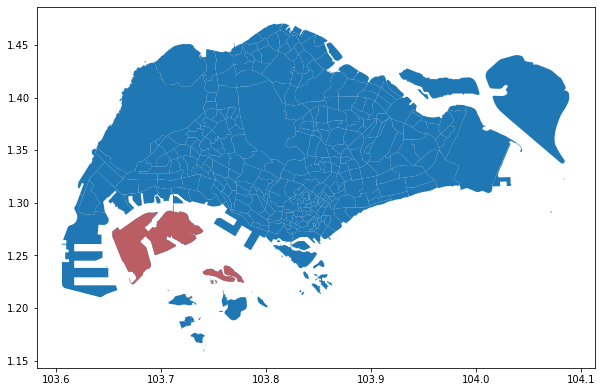

In [5]:
i = 3
target = subzones.iloc[[i]]
target_polygon = target['geometry'].iloc[0]
target_lat = target_polygon.centroid.y
target_lon = target_polygon.centroid.x
target_gh = coords_to_geohash(target_lat, target_lon)
plot_map(subzones, target)

False


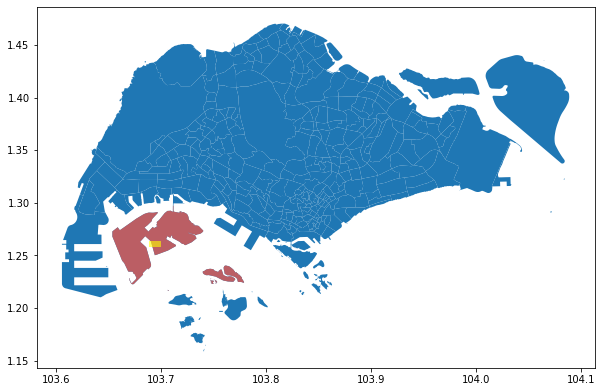

In [6]:
# single centroid geohash
gh_poly_expanded, polygons_gdf = expand_geohash_to_polygon(target_gh, 0)
plot_map(subzones, target, gh_poly_expanded)
print(gh_poly_expanded.contains(target_polygon))

True


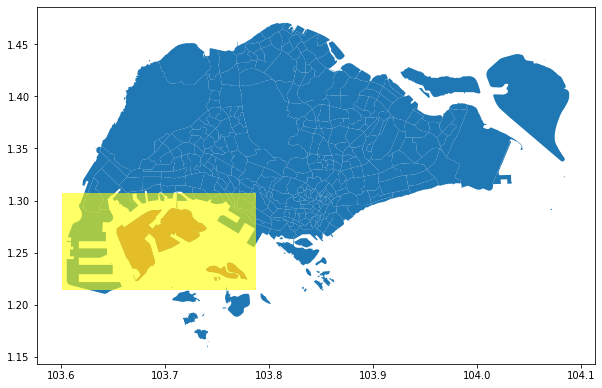

In [7]:
# geohashes expanded
gh_poly_expanded, polygons_gdf = expand_geohash_to_polygon(target_gh, 8)
plot_map(subzones, target, gh_poly_expanded)
print(gh_poly_expanded.contains(target_polygon))

Level 6 container found at expansion 8


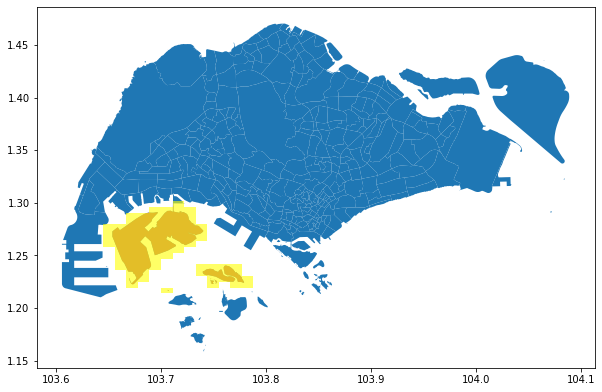

In [8]:
# run transformation function
output = transform_polygon_to_geohash(target_polygon)
plot_map(subzones, target, output)

Level 6 container found at expansion 8


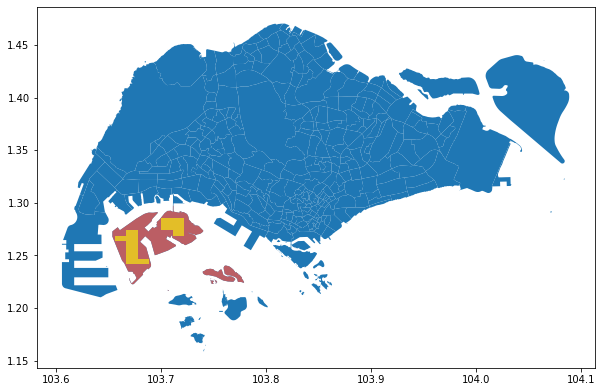

In [9]:
# run transformation function (within)
output = transform_polygon_to_geohash(target_polygon, op='within')
plot_map(subzones, target, output)

Level 5 container found at expansion 2


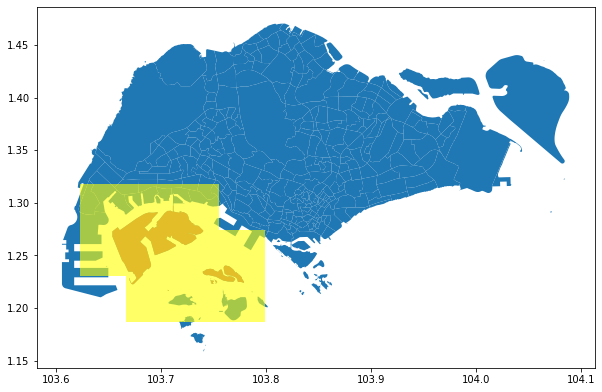

In [10]:
# try different geohash level (rough)
output = transform_polygon_to_geohash(target_polygon, 5)
plot_map(subzones, target, output)

Level 7 container found at expansion 58


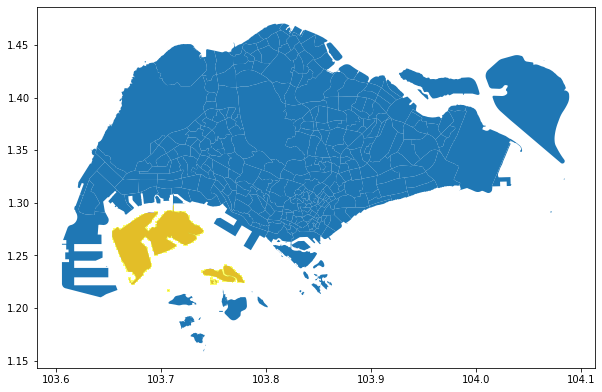

In [11]:
# try different geohash level (granular) (very slow)
output = transform_polygon_to_geohash(target_polygon, 7)
plot_map(subzones, target, output)

In [12]:
# this is the output Polygons we need (save as .geojson or .shp)
output.head()

,geohash,geometry
0,w21xr22,"POLYGON ((103.67935 1.27716, 103.67935 1.27579..."
1,w21xp99,"POLYGON ((103.69171 1.24008, 103.69171 1.23871..."
2,w21xpp7,"POLYGON ((103.67249 1.27167, 103.67249 1.27029..."
3,w21xnuz,"POLYGON ((103.66699 1.25793, 103.66699 1.25656..."
4,w21xpr5,"POLYGON ((103.68347 1.27029, 103.68347 1.26892..."


# Other Examples

Level 6 container found at expansion 2


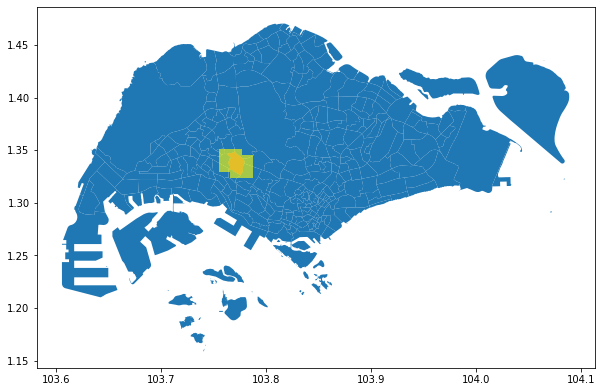

In [13]:
show_example(subzones, 200)

Level 7 container found at expansion 9


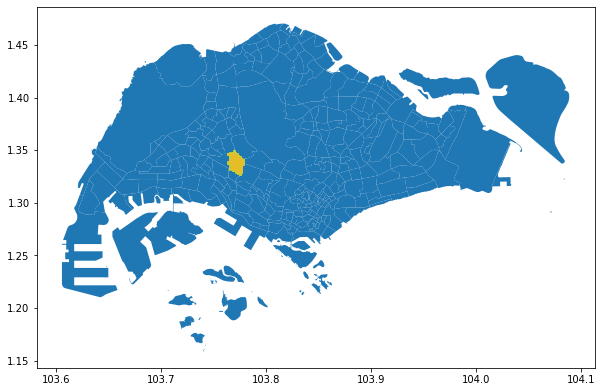

In [14]:
show_example(subzones, 200, 7)